In [2]:
!pip install optuna
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score,fbeta_score, roc_auc_score, roc_curve, confusion_matrix,classification_report, plot_roc_curve, accuracy_score
from sklearn.model_selection import train_test_split,cross_validate, KFold,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import svm
from xgboost import XGBClassifier
import optuna
import optuna.integration.lightgbm as lgb_optuna
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 1. Data loading and exploration

## 1.1 Loading data

In [3]:
#loading train data
train_device_model_df  = pd.read_sas('hash_school_device_model_fe.sas7bdat', index = 'abon_id')
train_dpi_df  = pd.read_sas('hash_school_device_dpi.sas7bdat', index = 'abon_id')
train_b_num_df = pd.read_sas('hash_school_device_b_num.sas7bdat', index = 'abon_id')

#converting features to float32 to reduce size
train_device_model_df=train_device_model_df.astype(np.float32)
train_dpi_df = train_dpi_df.astype(np.float32)
train_b_num_df.loc[:,[f for f in train_b_num_df.columns if f !='bnum']] = train_b_num_df.loc[:,[f for f in train_b_num_df.columns if f !='bnum']].astype(np.float32)

## 1.2 Basic exploratory analysis

### exploring main vitrin dataset

In [4]:
pd.set_option('display.max_columns', None)
train_device_model_df.head(100)

device_id  target  Balance_uah      TM_ID        lt  \
abon_id                                                          
1215806.0   100001.0     0.0    -0.005008  72.038651  4.650837   
1215139.0   100001.0     0.0     0.129405  72.038651  4.662159   
1236635.0   100001.0     0.0     0.000212  72.223106  4.544061   
1205230.0   100001.0     0.0     3.929049  72.223106  4.634513   
1019270.0   100001.0     0.0     0.799395  72.014153  4.584799   
...              ...     ...          ...        ...       ...   
1565554.0   100082.0     0.0     0.000009  71.721298  4.006258   
1624917.0   100085.0     1.0     0.015798  71.692833  3.898455   
1007282.0   100085.0     1.0     1.000706  71.703514  4.584698   
1032553.0   100086.0     0.0  4903.678711  72.223106  4.548678   
1090599.0   100086.0     0.0     0.007213  71.696396  4.668230   

           CALCULATION_METHOD_ID  loc_cnt_events  loc_is_obl_center  \
abon_id                                                               
1215806.0                    1.0            10.0                0.0   
1215139.0                    1.0            93.0                1.0   
1236635.0                    1.0            75.0                1.0   
1205230.0                    1.0           257.0                0.0   
1019270.0                    1.0           514.0                0.0   
...                          ...             ...                ...   
1565554.0                    1.0            52.0                0.0   
1624917.0                    1.0            15.0                0.0   
1007282.0                    1.0          1110.0                0.0   
1032553.0                    1.0           101.0                1.0   
1090599.0                    1.0            24.0                1.0   

             loc_lat    loc_lon  loc_market_share  bs_of_succ_but_drop_m1  \
abon_id                                                                     
1215806.0  15.005124  13.438293          0.000000                     NaN   
1215139.0  14.984766  13.193330          0.000000                0.693147   
1236635.0  15.302688  12.894875          0.605703                0.000000   
1205230.0  15.433531  10.478843          0.961503                0.000000   
1019270.0  15.122221  13.155303          0.393815                0.000000   
...              ...        ...               ...                     ...   
1565554.0  15.363262  12.553036          0.337849                0.000000   
1624917.0  15.355278  12.883719          0.605703                0.000000   
1007282.0  15.122221  13.155303          0.393815                0.000000   
1032553.0  15.373450  11.684129          1.498606                0.000000   
1090599.0  15.373450  11.684129          1.498606                0.000000   

           bs_of_succ_m1  bs_of_unsucc_attemp_equip_m1  \
abon_id                                                  
1215806.0            NaN                           NaN   
1215139.0       3.135494                      1.609438   
1236635.0       1.609438                      0.693147   
1205230.0       3.850147                      0.693147   
1019270.0       5.327876                      1.386294   
...                  ...                           ...   
1565554.0       0.000000                      0.000000   
1624917.0       0.000000                      0.000000   
1007282.0       5.908083                      0.693147   
1032553.0       1.609438                      0.000000   
1090599.0       0.693147                      0.693147   

           bs_of_unsucc_low_balance_m1  bs_of_attemps_all_m1  bs_of_recall_m1  \
abon_id                                                                         
1215806.0                          NaN                   NaN              NaN   
1215139.0                     0.000000              3.332205         0.000000   
1236635.0                     0.000000              0.693147         0.000000   
1205230.0                     0.000000              4.564348      

In [5]:
#all columns are numeric
train_device_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 205625 entries, 1215806.0 to 1492899.0
Columns: 877 entries, device_id to device_price
dtypes: float32(877)
memory usage: 689.5 MB


In [6]:
train_device_model_df.describe()

device_id         target   Balance_uah          TM_ID  \
count  205625.000000  205625.000000  2.044270e+05  204427.000000   
mean   109058.992188       0.242490 -1.742508e+13      71.859299   
std      4400.660645       0.428509  3.791837e+15       0.437032   
min    100001.000000       0.000000 -8.569925e+17      60.441849   
25%    105234.000000       0.000000  4.804599e-04      71.714188   
50%    109998.000000       0.000000  1.851271e-01      72.014153   
75%    113002.000000       0.000000  2.143376e+01      72.205780   
max    115057.000000       1.000000  1.672381e+15      72.569817   

                  lt  CALCULATION_METHOD_ID  loc_cnt_events  \
count  203510.000000          204427.000000   200406.000000   
mean        4.103243               1.079075      390.561310   
std         0.563597               0.269539     1048.107788   
min         0.226467               1.000000        1.000000   
25%         3.834646               1.000000       91.000000   
50%         4.277462               1.000000      236.000000   
75%         4.527421               1.000000      490.000000   
max         4.839041               2.000000   270915.000000   

       loc_is_obl_center        loc_lat        loc_lon  loc_market_share  \
count      200406.000000  200406.000000  200406.000000     200406.000000   
mean            0.403246      15.138448      12.072966          1.090360   
std             0.490633       0.210571       0.998799          1.257948   
min             0.000000      14.548182       9.612264          0.000000   
25%             0.000000      15.018142      11.684129          0.393815   
50%             0.000000      15.133760      12.280887          0.798434   
75%             1.000000      15.315289      12.894875          1.498606   
max             1.000000      15.652186      13.632522          8.166512   

       bs_of_succ_but_drop_m1  bs_of_succ_m1  bs_of_unsucc_attemp_equip_m1  \
count           175991.000000  175991.000000                 175991.000000   
mean                 0.363741       3.443190                      0.822810   
std                  0.627717       1.894210                      0.906525   
min                  0.000000       0.000000                      0.000000   
25%                  0.000000       2.197225                      0.000000   
50%                  0.000000       4.025352                      0.693147   
75%                  0.693147       4.890349                      1.386294   
max                  5.416101       7.810758                      6.354370   

       bs_of_unsucc_low_balance_m1  bs_of_attemps_all_m1  bs_of_recall_m1  \
count                175991.000000         175991.000000    175991.000000   
mean                      0.123482              3.284802         0.349886   
std                       0.428237              1.317329         0.547440   
min                       0.000000              0.000000         0.000000   
25%                       0.000000              2.397895         0.000000   
50%                       0.000000              3.465736         0.000000   
75%                       0.000000              4.276666         0.693147   
max                       6.965080              8.222822         5.030438   

        bs_succ_rate  bs_drop_call_rate   bs_drop_rate  bs_recall_rate  \
count  173807.000000      158317.000000  153626.000000   150130.000000   
mean        0.878330           0.105474       0.058368        0.007173   
std         0.530741           0.232807       0.162755        0.016966   
min         0.000000           0.000000       0.000000        0.000000   
25%         0.535837           0.000000       0.000000        0.000000   
50%         0.964022           0.027027       0.014286        0.000000   
75%         1.239691           0.069149       0.040650        0.009368   
max         4.127134           1.000000       1.000000        0.405465   

       serv_req_type_cnt  serv_cost_sum  serv_long_req_cnt  \
count       17227.0

In [7]:
#there are no rows with missing target
train_device_model_df.target.isnull().sum()

0

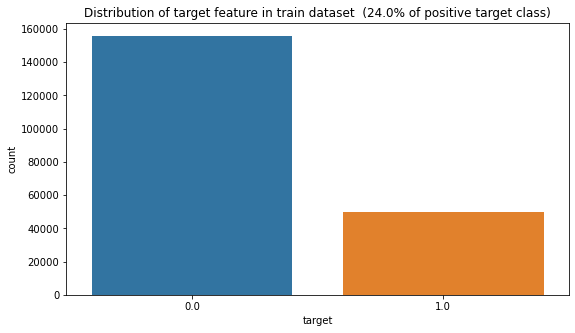

In [8]:
percentage_of_pos_target = round(100*(train_device_model_df.target==1).sum()/len(train_device_model_df),0)
sns.countplot(x=train_device_model_df.target).set_title(f'Distribution of target feature in train dataset  ({percentage_of_pos_target}% of positive target class)')
fig = plt.gcf()
fig.set_size_inches( 9, 5)

In [9]:
[(f,train_device_model_df[f].nunique()) for f in train_device_model_df.columns]

[('device_id', 12680),
 ('target', 2),
 ('Balance_uah', 196638),
 ('TM_ID', 75),
 ('lt', 7350),
 ('CALCULATION_METHOD_ID', 2),
 ('loc_cnt_events', 3651),
 ('loc_is_obl_center', 2),
 ('loc_lat', 1719),
 ('loc_lon', 1719),
 ('loc_market_share', 26),
 ('bs_of_succ_but_drop_m1', 90),
 ('bs_of_succ_m1', 998),
 ('bs_of_unsucc_attemp_equip_m1', 166),
 ('bs_of_unsucc_low_balance_m1', 132),
 ('bs_of_attemps_all_m1', 734),
 ('bs_of_recall_m1', 54),
 ('bs_succ_rate', 25207),
 ('bs_drop_call_rate', 9032),
 ('bs_drop_rate', 7609),
 ('bs_recall_rate', 3413),
 ('serv_req_type_cnt', 11),
 ('serv_cost_sum', 151),
 ('serv_long_req_cnt', 2),
 ('serv_act_days_count', 8),
 ('serv_add_4or2GB', 3),
 ('serv_quick_call', 5),
 ('serv_VF_bonus', 2),
 ('serv_protect_SIM', 2),
 ('serv_CLIR', 6),
 ('serv_add_10min', 2),
 ('serv_road_net', 3),
 ('serv_VIO_PASS', 3),
 ('serv_smart_1m', 2),
 ('serv_year_nopay', 2),
 ('serv_voice_post', 6),
 ('serv_rome_weekend', 6),
 ('serv_UAnoUA_30min', 6),
 ('tsoa_direct_cnt', 41),

#### After looking at data description file and on the count of unique values in columns, I came to conclusion that there are no categorical features that need to be encoded (those who exist only have 2 unique values)

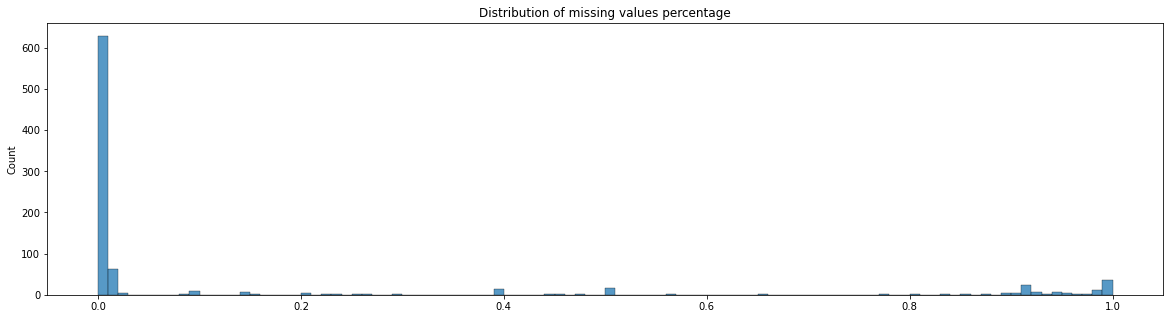

In [10]:
#most features have less than 1% of missing values
sns.histplot(train_device_model_df.isnull().sum()/len(train_device_model_df), binwidth=0.01).set_title('Distribution of missing values percentage')
fig = plt.gcf()
fig.set_size_inches( 20, 5)

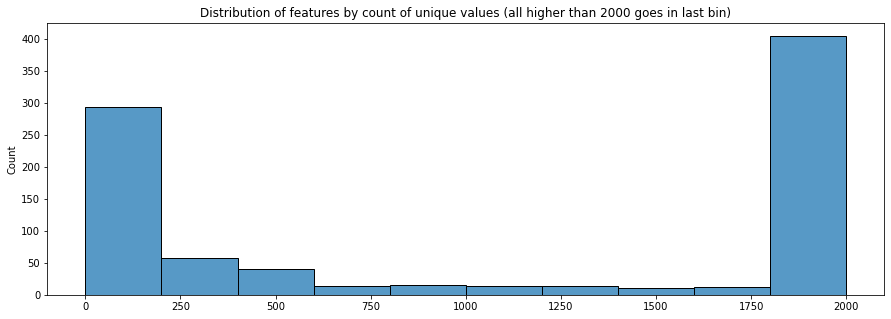

In [11]:
#almost half of features have unique values amount of less than 1% of dataset length
sns.histplot([train_device_model_df[f].nunique() if train_device_model_df[f].nunique()<2000 else 2000 for f in train_device_model_df.columns ],bins=10).set_title('Distribution of features by count of unique values (all higher than 2000 goes in last bin)')
fig = plt.gcf()
fig.set_size_inches( 15, 5)

### exploring dpi dataset


In [12]:
train_dpi_df.head(100)

,Application,SUM_of_Duration_sec,SUM_of_Volume_kb,SUM_of_Count_events,MAX_of_day_cnt
abon_id,,,,,
1000009.0,17.0,2.0,2.410000,8.0,3.0
1000009.0,232.0,1749.0,2190.770020,146.0,5.0
1000009.0,246.0,2997.0,1397.890015,102.0,4.0
1000009.0,249.0,694.0,52.669998,30.0,4.0
1000009.0,250.0,12268.0,11305.780273,552.0,4.0
...,...,...,...,...,...
1000015.0,824.0,2120.0,745.159973,234.0,13.0
1000015.0,839.0,18.0,177.229996,2.0,2.0
1000015.0,842.0,13305.0,8106.169922,720.0,14.0


In [13]:
grouped_dpi = train_dpi_df.groupby('Application').agg({'SUM_of_Duration_sec':'sum','SUM_of_Volume_kb':'sum','SUM_of_Count_events':'sum','MAX_of_day_cnt':'mean'})
grouped_dpi.head(5)

,SUM_of_Duration_sec,SUM_of_Volume_kb,SUM_of_Count_events,MAX_of_day_cnt
Application,,,,
6.0,263.0,9.463400e+02,159.0,1.076923
15.0,29014958.0,7.344890e+07,2221010.0,5.850965
17.0,41414924.0,5.334004e+08,27088152.0,5.494646
20.0,11.0,1.702000e+02,16.0,1.000000
23.0,91417.0,2.162449e+06,23216.0,1.367054


In [14]:
grouped_dpi.sort_values(by='SUM_of_Duration_sec', ascending = False).iloc[:10,:]

,SUM_of_Duration_sec,SUM_of_Volume_kb,SUM_of_Count_events,MAX_of_day_cnt
Application,,,,
250.0,3.325789e+10,1.038342e+11,1.455165e+09,19.109911
669.0,2.002380e+10,2.201570e+09,2.476628e+09,21.393156
246.0,1.738087e+10,9.191483e+10,5.714831e+08,18.413246
806.0,1.481288e+10,2.081270e+11,2.909041e+08,13.942219
842.0,9.410097e+09,1.458148e+10,5.051605e+08,19.215393
1406.0,5.585623e+09,2.540458e+10,1.380473e+08,8.299539
373.0,5.126766e+09,2.011801e+11,8.399142e+08,14.695656
249.0,4.297172e+09,7.625657e+09,2.071276e+08,15.501367
232.0,3.330515e+09,8.653674e+09,2.668303e+08,16.457209


In [15]:
print(f'{len(grouped_dpi)} unique apps')

719 unique apps


In [16]:
Duration = pd.Series(np.cumsum([f for f in grouped_dpi.SUM_of_Duration_sec.sort_values(ascending=False)])/grouped_dpi.SUM_of_Duration_sec.sum())
Duration = Duration[Duration<0.9]

Volume = pd.Series(np.cumsum([f for f in grouped_dpi.SUM_of_Volume_kb.sort_values(ascending=False)])/grouped_dpi.SUM_of_Volume_kb.sum())
Volume = Volume[Volume<0.9]

Events = pd.Series(np.cumsum([f for f in grouped_dpi.SUM_of_Count_events.sort_values(ascending=False)])/grouped_dpi.SUM_of_Count_events.sum())
Events = Events[Events<0.9]

#### TOP-10 apps by each metric account for >80% of traffic, events count and duration, also if app is in top N by one of metric,very often its also in top by all other metrics too

<AxesSubplot:>

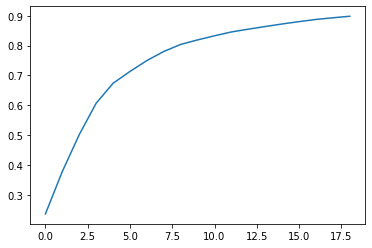

In [17]:
Duration.plot()

<AxesSubplot:title={'center':'Cumulative traffic volume % by TOP-applications\n (TOP-6 applications account for 80% of all traffic volume)'}>

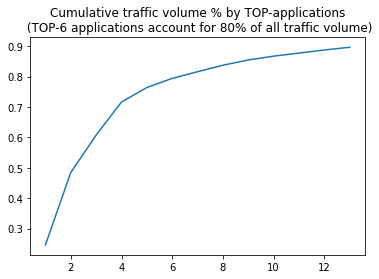

In [18]:
Volume.index = [f+1 for f in Volume.index]
Volume.plot(title = 'Cumulative traffic volume % by TOP-applications\n (TOP-6 applications account for 80% of all traffic volume)')

<AxesSubplot:>

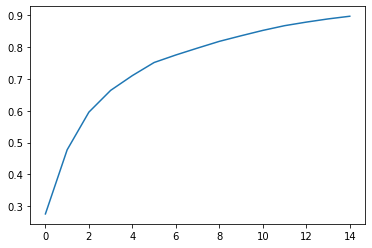

In [19]:
Events.plot()

In [20]:
top_dur = [f for f in grouped_dpi.index if f in (grouped_dpi.sort_values(by='SUM_of_Duration_sec', ascending = False).iloc[:10,:].index)]
top_vol = [f for f in grouped_dpi.index if f in (grouped_dpi.sort_values(by='SUM_of_Volume_kb', ascending = False).iloc[:10,:].index)]
top_events = [f for f in grouped_dpi.index if f in (grouped_dpi.sort_values(by='SUM_of_Count_events', ascending = False).iloc[:10,:].index)]
len(set(top_dur+top_vol+top_events))

15

### exploring bnum dataset


In [21]:
train_b_num_df.bnum.nunique()

16958

In [22]:
train_b_num_df

,bnum,call_cnt_out,call_cnt_in,call_dur_out,call_dur_in,cnt_sms_out,cnt_sms_in
abon_id,,,,,,,
1000006.0,b'311',1.0,0.0,13.0,0.0,0.0,0.0
1000006.0,b'7104',0.0,0.0,0.0,0.0,2.0,2.0
1000006.0,b'dzvinok',0.0,0.0,0.0,0.0,0.0,1.0
1000006.0,b'pensfond',0.0,0.0,0.0,0.0,0.0,6.0
1000006.0,b'sumyoenerg',0.0,0.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...
1888194.0,b'7979 taxi',0.0,0.0,0.0,0.0,0.0,1.0
1888194.0,b'aklas.ua',0.0,0.0,0.0,0.0,0.0,2.0
1888194.0,b'clearwater',0.0,0.0,0.0,0.0,0.0,5.0


In [23]:
#there are a lot of unique numbers, pivoted df will be sparse, need to filter out most of them 
train_b_num_df.bnum.nunique()

16958

In [24]:
grouped_bnum = train_b_num_df.groupby('bnum').agg({'call_cnt_out':'sum','call_cnt_in':'sum','cnt_sms_out':'sum','cnt_sms_in':'sum'})
grouped_bnum

,call_cnt_out,call_cnt_in,cnt_sms_out,cnt_sms_in
bnum,,,,
b'..neomag..',0.0,0.0,0.0,1.0
b'.adrenalin',0.0,0.0,0.0,1.0
b'00',0.0,1.0,0.0,0.0
b'000',0.0,0.0,2.0,0.0
b'001.com.ua',0.0,0.0,0.0,26.0
...,...,...,...,...
b'zvz.com.ua',0.0,0.0,0.0,25.0
b'zw store',0.0,0.0,0.0,1.0
b'zyabkin',0.0,0.0,0.0,3.0


In [25]:
grouped_bnum.call_cnt_out.sort_values(ascending=False)

bnum
b'111'           48717.0
b'3700'          33554.0
b'102'            1813.0
b'905'            1795.0
b'521'            1751.0
                  ...   
b'otppension'        0.0
b'otpbank'           0.0
b'otp bank'          0.0
b'otoplenie'         0.0
b'..neomag..'        0.0
Name: call_cnt_out, Length: 16958, dtype: float32

In [26]:
call_cnt_out = pd.Series(np.cumsum([f for f in grouped_bnum.call_cnt_out.sort_values(ascending=False)])/grouped_bnum.call_cnt_out.sum())
call_cnt_out = call_cnt_out[call_cnt_out<0.9]

call_cnt_in = pd.Series(np.cumsum([f for f in grouped_bnum.call_cnt_in.sort_values(ascending=False)])/grouped_bnum.call_cnt_in.sum())
call_cnt_in = call_cnt_in[call_cnt_in<0.999]

cnt_sms_out = pd.Series(np.cumsum([f for f in grouped_bnum.cnt_sms_out.sort_values(ascending=False)])/grouped_bnum.cnt_sms_out.sum())
cnt_sms_out = cnt_sms_out[cnt_sms_out<0.9]

cnt_sms_in = pd.Series(np.cumsum([f for f in grouped_bnum.cnt_sms_in.sort_values(ascending=False)])/grouped_bnum.cnt_sms_in.sum())
cnt_sms_in = cnt_sms_in[cnt_sms_in<0.9]

#### Same situation as regarding dpi df, very small fraction of nums account for >90% of events

<AxesSubplot:title={'center':'Cumulative outgoing calls % by TOP-alpha numbers\n (TOP-3 alpha numbers account for 80% of all outgoing calls)'}>

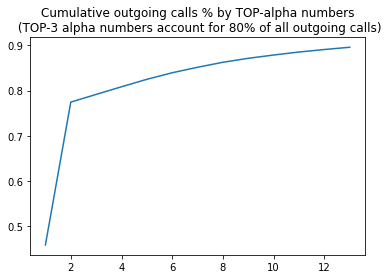

In [27]:
call_cnt_out.index = [f+1 for f in call_cnt_out.index]
call_cnt_out.plot(title = 'Cumulative outgoing calls % by TOP-alpha numbers\n (TOP-3 alpha numbers account for 80% of all outgoing calls)')

<AxesSubplot:>

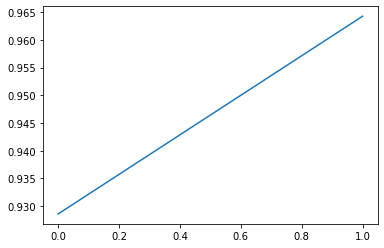

In [28]:
call_cnt_in.plot()

<AxesSubplot:>

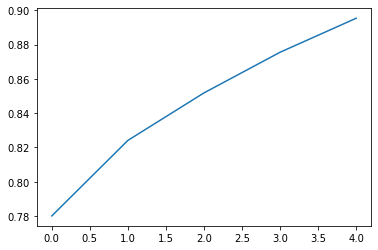

In [29]:
cnt_sms_out.plot()

<AxesSubplot:>

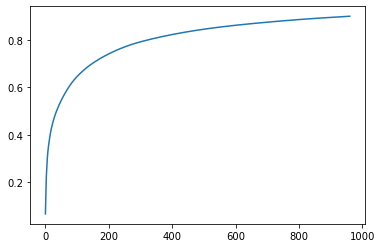

In [30]:
cnt_sms_in.plot()

# 2. Data preprocessing

In [31]:
abon_dpi_agg = train_dpi_df.groupby('abon_id').agg({'SUM_of_Duration_sec':'sum','SUM_of_Volume_kb':'sum','SUM_of_Count_events':'sum', 'MAX_of_day_cnt':'mean'})
bnum_df_agg = train_b_num_df.groupby('abon_id').agg({'call_cnt_out':'sum','call_cnt_in':'sum','call_dur_out':'sum', 'call_dur_in':'sum', 'cnt_sms_out':'sum', 'cnt_sms_in':'sum'})

In [32]:
abon_dpi_agg.columns = [''.join([f,'_DPI']) for f in abon_dpi_agg.columns]
bnum_df_agg.columns = [''.join([f,'_DPI']) for f in bnum_df_agg.columns]

In [33]:
#Making pivot table from dpi df to later merge it with main vitrin dataframe
train_dpi_df = train_dpi_df.pivot_table(index = train_dpi_df.index, columns= 'Application', values=['SUM_of_Duration_sec','SUM_of_Volume_kb','SUM_of_Count_events','MAX_of_day_cnt'])
train_dpi_df.columns = train_dpi_df.columns.map('{0[1]}|{0[0]}'.format)

In [34]:
#Selecting top bnums with which most subscribers interract by sms count and minutes dur criterion,
#filtering out those who are used by less than 1% of subscribers, making pivot table from bnum df 

train_b_num_df['bnum'] = [str(f)[2:-1] for f in train_b_num_df['bnum']]
bnum_agg_data = train_b_num_df.groupby('bnum').agg({'call_cnt_out':'sum','cnt_sms_in':'sum'}).reset_index()
top_bnum = set([*bnum_agg_data.nlargest(200,'call_cnt_out').bnum.values, *bnum_agg_data.nlargest(200,'cnt_sms_in').bnum.values])
train_b_num_df = train_b_num_df.loc[train_b_num_df.bnum.isin(top_bnum),:]
train_b_num_df = train_b_num_df.pivot_table(index = train_b_num_df.index, columns= 'bnum', values=['call_cnt_out','cnt_sms_in','cnt_sms_out'])
train_b_num_df.columns = train_b_num_df.columns.map('{0[1]}|{0[0]}'.format)
needed_columns = [f for f in train_b_num_df.columns if train_b_num_df[f].isnull().sum()/len(train_b_num_df[f])>0.01]
train_b_num_df = train_b_num_df.loc[:,needed_columns]

In [35]:
#merging dataframes
train_device_model_df = pd.merge(train_device_model_df,train_dpi_df, left_index=True, right_index=True , how = 'left' ).merge(abon_dpi_agg,left_index=True, right_index=True , how = 'left' ).merge(bnum_df_agg,left_index=True, right_index=True , how = 'left' ).merge(train_b_num_df,left_index=True, right_index=True , how = 'left' )

In [36]:
#releasing memory
train_dpi_df = None
train_b_num_df = None

In [37]:
#dropping features that have only one unique value
bad_features = [f for f in train_device_model_df.columns if len(train_device_model_df[f].unique())<=1]
train_device_model_df = train_device_model_df.drop(columns = bad_features)

In [38]:
# imputing missing values with median values for each feature (median is more robust, as it is hard to account for data
# distribution after encryption, also it showed better results empirically comparing to mean imputation)
train_device_model_df = train_device_model_df.fillna(train_device_model_df.median())

In [39]:
# handling severe outliers using isolation forest algorithm (again as it is hard to select one method for all features that is
# based on distribution of the feature due to encryption)
outlier_detector = IsolationForest(contamination=0.01)
outlier_predictions = outlier_detector.fit_predict(train_device_model_df)
mask = outlier_predictions == -1
train_device_model_df.loc[mask,train_device_model_df.columns != 'target'] = np.nan
train_device_model_df = train_device_model_df.fillna(train_device_model_df.median())

In [40]:
# Using different kinds of scaling made model performance on both validation and test sets worse, so I skip this step as
# scaling is not generally required when using tree-based methods, which I chose as final algorithms type  

"""
#scaling data using min-max method now that severe outliers were treated
minmax_scaler = MinMaxScaler()
scaled_data = minmax_scaler.fit_transform(train_device_model_df)

#save scaler to use same scaler later on on test dataset

joblib.dump(minmax_scaler, 'minmax_scaler.bin', compress=True)

train_device_model_df = pd.DataFrame(scaled_data, index=train_device_model_df.index, columns=train_device_model_df.columns)
"""

"\n#scaling data using min-max method now that severe outliers were treated\nminmax_scaler = MinMaxScaler()\nscaled_data = minmax_scaler.fit_transform(train_device_model_df)\n\n#save scaler to use same scaler later on on test dataset\n\njoblib.dump(minmax_scaler, 'minmax_scaler.bin', compress=True)\n\ntrain_device_model_df = pd.DataFrame(scaled_data, index=train_device_model_df.index, columns=train_device_model_df.columns)\n"

# 3. Models selection and hyperparameters tuning

### -For given binary classification task I chose performance-oriented near state-of-art models : LightGBM, XGBoost and RandomForest, which are all tree-based classification models.  
### -For hyperparameter tuning, I used Optuna library which helps to set up randomized and step-wise hyperparameter tuning process
### -Before tuning each model, I reduced number of features using feature importance metrics

## 3.0 Baseline (Logistic regression)

In [43]:
train_device_model_df_valid = train_device_model_df.copy()

minmax_scaler = MinMaxScaler()

scaled_data = minmax_scaler.fit_transform(train_device_model_df_valid.drop(columns="target"))

train_device_model_df_valid = pd.DataFrame(scaled_data, index=train_device_model_df.index, columns=train_device_model_df.drop(columns="target").columns);train_device_model_df_valid=train_device_model_df
LogReg_clf = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
train_device_model_df_valid["target"]=train_device_model_df.target
                                                                                                                                                                                                                                

eval_baseline = cross_validate(LogReg_clf, train_device_model_df_valid.drop(columns="target"), train_device_model_df_valid.target, cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True), scoring=['roc_auc','f1','precision','recall'])

print("Baseline classifier model evaluation results:\n")
for key, val in eval_baseline.items():
    print(f'Mean {key} is {np.mean(val).round(2)}')

Baseline classifier model evaluation results:

Mean fit_time is 24.99
Mean score_time is 2.47
Mean test_roc_auc is 0.52
Mean test_f1 is 0.36
Mean test_precision is 0.25
Mean test_recall is 0.62


## 3.1 lightGBM

In [44]:
train_device_model_df_valid = train_device_model_df.copy()

In [45]:
#Training simple model to select only important features
param = {
            "objective": "binary",
            "metric": "auc",
            "verbosity": -1,
            "boosting_type": "gbdt"
        }

train_x, valid_x, train_y, valid_y = train_test_split(train_device_model_df_valid.drop('target', axis=1), train_device_model_df_valid.target, test_size=0.2)
dtrain = lgb.Dataset(train_x, label=train_y)
dvalid = lgb.Dataset(valid_x, label=valid_y)

train_start_time = time.perf_counter()

lgbm_simple = lgb.train(
            param, dtrain, valid_sets=[dvalid], verbose_eval=False
        )

training_end_time = time.perf_counter()

lightgbm_train_time = training_end_time-train_start_time  

In [46]:
train_x = None
valid_x= None
train_y= None
valid_y =  None

In [47]:
%%capture
#Getting importance of each feature by split and gain metrics

split_plot = lgb.plot_importance(lgbm_simple, importance_type='split')

gain_plot = lgb.plot_importance(lgbm_simple, importance_type='gain')

split_feature_importance = [f for f in zip([f.get_text() for f in split_plot.yaxis.get_majorticklabels()],[f.get_bbox().get_points()[1][0] for f in split_plot.patches])]
gain_feature_importance = [f for f in zip([f.get_text() for f in gain_plot.yaxis.get_majorticklabels()],[f.get_bbox().get_points()[1][0] for f in gain_plot.patches])]

In [48]:
#get all features that account for 99% of importance using split metric

cumsum_imp = np.cumsum([f[1] for f in split_feature_importance][::-1])
break_point = cumsum_imp[-1] * 0.99
split_feature_treshold = np.argmax(cumsum_imp >= break_point) + 1

In [49]:
#get all features that account for 99% of importance using gain metric

cumsum_imp = np.cumsum([f[1] for f in gain_feature_importance][::-1])
break_point = cumsum_imp[-1] * 0.99
gain_feature_treshold = np.argmax(cumsum_imp >= break_point) + 1

In [50]:
#Leave features that are in either of lists
important_features_lgbm = list(set([f[0] for f in gain_feature_importance[-gain_feature_treshold:]] + [f[0] for f in split_feature_importance[-split_feature_treshold:]]))
important_features_lgbm.append('target')

In [51]:
train_device_model_df_valid = train_device_model_df_valid.loc[:,[f for f in important_features_lgbm if f in train_device_model_df_valid.columns]]

In [52]:
#Hyperparameter tuning using step-wise algorithm with 3-Fold CV, early-stoppings and accounting for unbalanced classes

dtrain = lgb.Dataset(train_device_model_df_valid.drop(columns = ['target']), label=train_device_model_df_valid.target)

params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "is_unbalance": True
}

tuner = lgb_optuna.LightGBMTunerCV(
    params, dtrain, verbose_eval=100, early_stopping_rounds=100, folds=KFold(n_splits=3) )

tuner.run()

print("Best score:", tuner.best_score)
best_params_lgb = tuner.best_params
print("Best params:", best_params_lgb)
print("  Params: ")
for key, value in best_params_lgb.items():
    print("    {}: {}".format(key, value))
    
best_params_lgb['is_unbalance'] = True

[I 2021-03-17 19:31:00,282] A new study created in memory with name: no-name-6f709acc-d8dc-4b9d-b7f1-662594327879
feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.675744 + 0.00509623
[200]	cv_agg's auc: 0.673441 + 0.00618885


feature_fraction, val_score: 0.675842:  14%|#4        | 1/7 [00:42<04:16, 42.75s/it]

[100]	cv_agg's auc: 0.677538 + 0.00271513
[200]	cv_agg's auc: 0.6769 + 0.0025534


feature_fraction, val_score: 0.677663:  29%|##8       | 2/7 [01:26<03:35, 43.09s/it]

[100]	cv_agg's auc: 0.677354 + 0.00410174


feature_fraction, val_score: 0.677663:  43%|####2     | 3/7 [02:11<02:53, 43.48s/it]

[100]	cv_agg's auc: 0.674159 + 0.0102243


feature_fraction, val_score: 0.677663:  57%|#####7    | 4/7 [02:54<02:10, 43.35s/it]

[100]	cv_agg's auc: 0.677233 + 0.00370628
[200]	cv_agg's auc: 0.674749 + 0.00423625


feature_fraction, val_score: 0.677734:  71%|#######1  | 5/7 [03:37<01:26, 43.48s/it]

[100]	cv_agg's auc: 0.67583 + 0.0046434


feature_fraction, val_score: 0.677734:  86%|########5 | 6/7 [04:24<00:44, 44.43s/it]

[100]	cv_agg's auc: 0.677266 + 0.00329744


num_leaves, val_score: 0.677734:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.667013 + 0.00398602
[200]	cv_agg's auc: 0.673024 + 0.00306182
[300]	cv_agg's auc: 0.673563 + 0.00353768
[400]	cv_agg's auc: 0.67431 + 0.0034493
[500]	cv_agg's auc: 0.674479 + 0.00333485
[600]	cv_agg's auc: 0.674858 + 0.00364379


num_leaves, val_score: 0.677734:   5%|5         | 1/20 [01:08<21:40, 68.43s/it]

[100]	cv_agg's auc: 0.661713 + 0.00595053


num_leaves, val_score: 0.677734:  10%|#         | 2/20 [02:27<21:31, 71.73s/it]

[100]	cv_agg's auc: 0.67604 + 0.0064554


num_leaves, val_score: 0.677734:  15%|#5        | 3/20 [03:12<17:59, 63.49s/it]

[100]	cv_agg's auc: 0.668521 + 0.00442997


num_leaves, val_score: 0.677734:  20%|##        | 4/20 [04:17<17:02, 63.92s/it]

[100]	cv_agg's auc: 0.676458 + 0.00429652


num_leaves, val_score: 0.677734:  25%|##5       | 5/20 [05:05<14:47, 59.14s/it]

[100]	cv_agg's auc: 0.669172 + 0.00443025


num_leaves, val_score: 0.677734:  30%|###       | 6/20 [06:14<14:30, 62.19s/it]

[100]	cv_agg's auc: 0.674617 + 0.0066051


num_leaves, val_score: 0.677734:  35%|###5      | 7/20 [06:59<12:23, 57.18s/it]

[100]	cv_agg's auc: 0.662896 + 0.00588875


num_leaves, val_score: 0.677734:  40%|####      | 8/20 [08:15<12:33, 62.75s/it]

[100]	cv_agg's auc: 0.669728 + 0.00616849


num_leaves, val_score: 0.677734:  45%|####5     | 9/20 [09:11<11:07, 60.65s/it]

[100]	cv_agg's auc: 0.668335 + 0.00626375


num_leaves, val_score: 0.677734:  50%|#####     | 10/20 [10:11<10:03, 60.38s/it]

[100]	cv_agg's auc: 0.674473 + 0.00524219


num_leaves, val_score: 0.677734:  55%|#####5    | 11/20 [11:04<08:44, 58.32s/it]

[100]	cv_agg's auc: 0.666245 + 0.00413097
[200]	cv_agg's auc: 0.673533 + 0.00315439
[300]	cv_agg's auc: 0.675217 + 0.00341264
[400]	cv_agg's auc: 0.676258 + 0.00303951
[500]	cv_agg's auc: 0.67598 + 0.00368978


num_leaves, val_score: 0.677734:  60%|######    | 12/20 [12:00<07:41, 57.74s/it]

[100]	cv_agg's auc: 0.659149 + 0.00622769
[200]	cv_agg's auc: 0.667084 + 0.00666187
[300]	cv_agg's auc: 0.669502 + 0.00600692
[400]	cv_agg's auc: 0.671156 + 0.00580041
[500]	cv_agg's auc: 0.672402 + 0.00503948
[600]	cv_agg's auc: 0.673059 + 0.0051829
[700]	cv_agg's auc: 0.67381 + 0.00491345
[800]	cv_agg's auc: 0.673734 + 0.00484216


num_leaves, val_score: 0.677734:  65%|######5   | 13/20 [13:13<07:14, 62.09s/it]

[100]	cv_agg's auc: 0.67409 + 0.00712478


num_leaves, val_score: 0.677734:  70%|#######   | 14/20 [13:54<05:35, 55.92s/it]

[100]	cv_agg's auc: 0.674101 + 0.00540091


num_leaves, val_score: 0.677734:  75%|#######5  | 15/20 [14:47<04:34, 54.92s/it]

[100]	cv_agg's auc: 0.674477 + 0.00420387
[200]	cv_agg's auc: 0.676081 + 0.0033783


num_leaves, val_score: 0.677734:  80%|########  | 16/20 [15:28<03:22, 50.75s/it]

[100]	cv_agg's auc: 0.672657 + 0.00713837


num_leaves, val_score: 0.677734:  85%|########5 | 17/20 [16:19<02:32, 50.83s/it]

[100]	cv_agg's auc: 0.673802 + 0.00722389
[200]	cv_agg's auc: 0.673361 + 0.00624047


num_leaves, val_score: 0.677734:  90%|######### | 18/20 [17:02<01:36, 48.42s/it]

[100]	cv_agg's auc: 0.669958 + 0.00467397


num_leaves, val_score: 0.677734:  95%|#########5| 19/20 [17:58<00:50, 50.94s/it]

[100]	cv_agg's auc: 0.674765 + 0.00603599
[200]	cv_agg's auc: 0.670513 + 0.00559684


bagging, val_score: 0.677734:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.668572 + 0.00308757


bagging, val_score: 0.677734:  10%|#         | 1/10 [00:35<05:23, 35.94s/it]

[100]	cv_agg's auc: 0.675752 + 0.00460185
[200]	cv_agg's auc: 0.673527 + 0.00451267


bagging, val_score: 0.677734:  20%|##        | 2/10 [01:20<05:07, 38.49s/it]

[100]	cv_agg's auc: 0.67305 + 0.00404666


bagging, val_score: 0.677734:  30%|###       | 3/10 [01:58<04:29, 38.52s/it]

[100]	cv_agg's auc: 0.670705 + 0.00612392


bagging, val_score: 0.677734:  40%|####      | 4/10 [02:37<03:51, 38.56s/it]

[100]	cv_agg's auc: 0.669025 + 0.00655779


bagging, val_score: 0.677734:  50%|#####     | 5/10 [03:12<03:06, 37.35s/it]

[100]	cv_agg's auc: 0.67407 + 0.00454722
[200]	cv_agg's auc: 0.672301 + 0.00447755


bagging, val_score: 0.677734:  60%|######    | 6/10 [03:54<02:35, 38.93s/it]

[100]	cv_agg's auc: 0.671357 + 0.00548481


bagging, val_score: 0.677734:  70%|#######   | 7/10 [04:33<01:57, 39.01s/it]

[100]	cv_agg's auc: 0.675711 + 0.00584521


bagging, val_score: 0.677734:  80%|########  | 8/10 [05:17<01:20, 40.26s/it]

[200]	cv_agg's auc: 0.674006 + 0.00572353
[100]	cv_agg's auc: 0.673111 + 0.0050744
[200]	cv_agg's auc: 0.670014 + 0.00458234


bagging, val_score: 0.677734:  90%|######### | 9/10 [05:56<00:39, 39.91s/it]

[100]	cv_agg's auc: 0.675969 + 0.00416577
[200]	cv_agg's auc: 0.674084 + 0.00433782


feature_fraction_stage2, val_score: 0.677734:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.677722 + 0.00391532
[200]	cv_agg's auc: 0.676111 + 0.00312904


feature_fraction_stage2, val_score: 0.677855:  17%|#6        | 1/6 [00:42<03:33, 42.68s/it]

[100]	cv_agg's auc: 0.676467 + 0.00431186


feature_fraction_stage2, val_score: 0.677855:  33%|###3      | 2/6 [01:23<02:48, 42.21s/it]

[100]	cv_agg's auc: 0.676415 + 0.00389104
[200]	cv_agg's auc: 0.674914 + 0.00316915


feature_fraction_stage2, val_score: 0.677855:  50%|#####     | 3/6 [02:05<02:06, 42.11s/it]

[100]	cv_agg's auc: 0.675372 + 0.00631345


feature_fraction_stage2, val_score: 0.677855:  67%|######6   | 4/6 [02:47<01:24, 42.12s/it]

[200]	cv_agg's auc: 0.673857 + 0.00559514
[100]	cv_agg's auc: 0.677408 + 0.00465072
[200]	cv_agg's auc: 0.6749 + 0.00578023


feature_fraction_stage2, val_score: 0.677855:  83%|########3 | 5/6 [03:30<00:42, 42.26s/it]

[100]	cv_agg's auc: 0.675915 + 0.00545885
[200]	cv_agg's auc: 0.673329 + 0.00675002


regularization_factors, val_score: 0.677855:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.677534 + 0.00374426


regularization_factors, val_score: 0.677855:   5%|5         | 1/20 [00:40<12:57, 40.90s/it]

[100]	cv_agg's auc: 0.677904 + 0.00372365
[200]	cv_agg's auc: 0.675773 + 0.00378624


regularization_factors, val_score: 0.678233:  10%|#         | 2/20 [01:23<12:26, 41.47s/it]

[100]	cv_agg's auc: 0.677722 + 0.00391532
[200]	cv_agg's auc: 0.676111 + 0.00312904


regularization_factors, val_score: 0.678233:  15%|#5        | 3/20 [02:07<11:54, 42.04s/it]

[100]	cv_agg's auc: 0.677762 + 0.00609959


regularization_factors, val_score: 0.678565:  20%|##        | 4/20 [02:51<11:26, 42.88s/it]

[100]	cv_agg's auc: 0.676732 + 0.00476743
[200]	cv_agg's auc: 0.674828 + 0.00576943


regularization_factors, val_score: 0.678565:  25%|##5       | 5/20 [03:37<10:54, 43.60s/it]

[100]	cv_agg's auc: 0.677573 + 0.0050007


regularization_factors, val_score: 0.678565:  30%|###       | 6/20 [04:16<09:52, 42.34s/it]

[100]	cv_agg's auc: 0.677721 + 0.00391548
[200]	cv_agg's auc: 0.675293 + 0.00413272


regularization_factors, val_score: 0.678565:  35%|###5      | 7/20 [05:01<09:22, 43.24s/it]

[100]	cv_agg's auc: 0.678016 + 0.0038688
[200]	cv_agg's auc: 0.675853 + 0.00433758


regularization_factors, val_score: 0.678565:  40%|####      | 8/20 [05:46<08:43, 43.59s/it]

[100]	cv_agg's auc: 0.677722 + 0.00391532
[200]	cv_agg's auc: 0.676111 + 0.00312904


regularization_factors, val_score: 0.678565:  45%|####5     | 9/20 [06:29<07:58, 43.50s/it]

[100]	cv_agg's auc: 0.677722 + 0.00391532
[200]	cv_agg's auc: 0.676111 + 0.00312904


regularization_factors, val_score: 0.678565:  50%|#####     | 10/20 [07:13<07:15, 43.54s/it]

[100]	cv_agg's auc: 0.678078 + 0.00422325
[200]	cv_agg's auc: 0.678141 + 0.00341589


regularization_factors, val_score: 0.678767:  55%|#####5    | 11/20 [08:02<06:45, 45.11s/it]

[100]	cv_agg's auc: 0.678493 + 0.00452504
[200]	cv_agg's auc: 0.677778 + 0.00451708


regularization_factors, val_score: 0.679128:  60%|######    | 12/20 [08:49<06:07, 45.91s/it]

[100]	cv_agg's auc: 0.678038 + 0.00457819
[200]	cv_agg's auc: 0.678751 + 0.00425043


regularization_factors, val_score: 0.679128:  65%|######5   | 13/20 [09:36<05:23, 46.27s/it]

[100]	cv_agg's auc: 0.675596 + 0.00440786


regularization_factors, val_score: 0.679128:  70%|#######   | 14/20 [10:17<04:26, 44.44s/it]

[100]	cv_agg's auc: 0.677265 + 0.00435024
[200]	cv_agg's auc: 0.675182 + 0.00516805


regularization_factors, val_score: 0.679128:  75%|#######5  | 15/20 [11:01<03:41, 44.27s/it]

[100]	cv_agg's auc: 0.677721 + 0.00391553
[200]	cv_agg's auc: 0.676162 + 0.00311551


regularization_factors, val_score: 0.679128:  80%|########  | 16/20 [11:46<02:58, 44.50s/it]

[100]	cv_agg's auc: 0.677964 + 0.00395296
[200]	cv_agg's auc: 0.677312 + 0.00432864


regularization_factors, val_score: 0.679128:  85%|########5 | 17/20 [12:32<02:15, 45.16s/it]

[100]	cv_agg's auc: 0.67608 + 0.00522571


regularization_factors, val_score: 0.679128:  90%|######### | 18/20 [13:12<01:27, 43.58s/it]

[100]	cv_agg's auc: 0.678013 + 0.00386297
[200]	cv_agg's auc: 0.676578 + 0.00288292


regularization_factors, val_score: 0.679128:  95%|#########5| 19/20 [13:59<00:44, 44.53s/it]

[100]	cv_agg's auc: 0.674251 + 0.00896773
[200]	cv_agg's auc: 0.673562 + 0.0080554


min_data_in_leaf, val_score: 0.679128:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.678621 + 0.00447294
[200]	cv_agg's auc: 0.678978 + 0.00396602


min_data_in_leaf, val_score: 0.679128:  20%|##        | 1/5 [00:57<03:49, 57.49s/it]

[100]	cv_agg's auc: 0.678526 + 0.00493591


min_data_in_leaf, val_score: 0.679128:  40%|####      | 2/5 [01:40<02:39, 53.16s/it]

[100]	cv_agg's auc: 0.67849 + 0.00423522
[200]	cv_agg's auc: 0.678994 + 0.00517613


min_data_in_leaf, val_score: 0.679631:  60%|######    | 3/5 [02:29<01:43, 51.78s/it]

[100]	cv_agg's auc: 0.678621 + 0.00447294
[200]	cv_agg's auc: 0.678144 + 0.00487327


min_data_in_leaf, val_score: 0.679631:  80%|########  | 4/5 [03:21<00:51, 51.91s/it]

[100]	cv_agg's auc: 0.678439 + 0.00442203
[200]	cv_agg's auc: 0.678465 + 0.00396275


min_data_in_leaf, val_score: 0.679631: 100%|##########| 5/5 [04:07<00:00, 49.60s/it]

Best score: 0.6796309791714003
Best params: {'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'boosting_type': 'gbdt', 'is_unbalance': True, 'feature_pre_filter': False, 'lambda_l1': 8.599914241598706, 'lambda_l2': 1.2597065318980905e-05, 'num_leaves': 31, 'feature_fraction': 0.6479999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 100}
  Params: 
    objective: binary
    metric: auc
    verbosity: -1
    boosting_type: gbdt
    is_unbalance: True
    feature_pre_filter: False
    lambda_l1: 8.599914241598706
    lambda_l2: 1.2597065318980905e-05
    num_leaves: 31
    feature_fraction: 0.6479999999999999
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 100


#### Evaluation of best model using 10-Fold Stratified CV

In [53]:
def evaluate_model(model, folds, X,y, scoring_metrics):
    kfold = StratifiedKFold(n_splits=folds, random_state=17, shuffle=True)
    results = cross_validate(model,X,y, cv=kfold, scoring=scoring_metrics)                                 
    
    return results

In [54]:
cv_lgbm_clf = lgb.LGBMClassifier(n_estimators=1000, **best_params_lgb)
cv_lgbm_clf.fit(train_device_model_df_valid.drop(columns = ['target']), train_device_model_df_valid.target)

eval_lgbm = evaluate_model(cv_lgbm_clf,10,train_device_model_df_valid.drop(columns="target"), train_device_model_df_valid.target,['roc_auc','f1','precision','recall'])

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6479999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6479999999999999
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1.2597065318980905e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2597065318980905e-05
[LightGBM] [Warning] lambda_l1 is set=8.599914241598706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.599914241598706
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6479999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6479999999999999
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Curre

## 3.2 XGBoost

#### Below are same steps as for LightGBM model

In [55]:
train_device_model_df_valid = train_device_model_df.copy()

In [56]:
%%capture 

train_x, valid_x, train_y, valid_y = train_test_split(train_device_model_df_valid.drop('target', axis=1), train_device_model_df_valid.target, test_size=0.2)
dtrain = xgb.DMatrix(train_x, train_y)
dvalid = xgb.DMatrix(valid_x, valid_y)

param = {"objective": "binary:logistic",
        "eval_metric": "auc",
        'max_depth': 6,
        'learning_rate': 0.1, 
         'scale_pos_weight':3}



xgbm_simple = xgb.train(param, dtrain, 100, [(dvalid, 'valid')])

In [57]:
train_x = None
valid_x= None
train_y= None
valid_y =  None

In [58]:
gain_feature_importance = (sorted(xgbm_simple.get_score(importance_type='gain').items(), key=lambda item: item[1]))
weight_feature_importance = (sorted(xgbm_simple.get_score(importance_type='weight').items(), key=lambda item: item[1]))

In [59]:
cumsum_imp = np.cumsum([f[1] for f in weight_feature_importance][::-1])
break_point = cumsum_imp[-1] * 0.99
weight_feature_treshold = np.argmax(cumsum_imp >= break_point) + 1

In [60]:
cumsum_imp = np.cumsum([f[1] for f in gain_feature_importance][::-1])
break_point = cumsum_imp[-1] * 0.99
gain_feature_treshold = np.argmax(cumsum_imp >= break_point) + 1

In [61]:
important_features_xgb = list(set([f[0] for f in gain_feature_importance[-gain_feature_treshold:]] + [f[0] for f in weight_feature_importance[-weight_feature_treshold:]]))
important_features_xgb.append('target')

In [62]:
train_device_model_df_valid = train_device_model_df_valid.loc[:,[f for f in important_features_xgb if f in train_device_model_df_valid.columns]]

In [63]:
#Randomized grid-search with 3-Fold CV and with pruning of unpromising tries (early-stoppings)

class Objective(object):
    def __init__(self, df):
        self.df = df

    def __call__(self, trial):
        
        dtrain = xgb.DMatrix(self.df.drop('target', axis=1), label = self.df.target)
        
        param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        'scale_pos_weight': 3,
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        
            
        }
        
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-auc")
        
        history = xgb.cv(param, dtrain, num_boost_round=100, callbacks=[pruning_callback])
        
        mean_auc = history["test-auc-mean"].values[-1]
        
        return mean_auc





In [ ]:
objective = Objective(train_device_model_df_valid)

pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)

study = optuna.create_study(pruner=pruner, direction="maximize")

study.optimize(objective, n_trials=100)


trial = study.best_trial

best_params_xgb = trial.params
best_params_xgb['scale_pos_weight'] = 3

print("Best score:", trial.value)
print("Best params:", best_params_xgb)

#### Evaluation of best model using 10-Fold Stratified CV

In [65]:
cv_xgb_clf = XGBClassifier(n_estimators=100, **best_params_xgb)

cv_xgb_clf.fit(train_device_model_df_valid.drop(columns = ['target']), train_device_model_df_valid.target)

/home/Ihor/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(alpha=3.2687629688203456e-07, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0.010416712364682487, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=0.1505882508658104,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=3.26876318e-07, reg_lambda=0.150588244,
              scale_pos_weight=3, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [66]:
%%capture
eval_xgb = evaluate_model(cv_xgb_clf,10,train_device_model_df_valid.drop(columns="target"), train_device_model_df_valid.target,['roc_auc','f1','precision','recall'])

## 3.3 Random Forest

In [67]:
# Below are same steps as for models above

In [68]:
train_device_model_df_valid = train_device_model_df.copy()

In [69]:
train_device_model_df_valid = train_device_model_df_valid.fillna(train_device_model_df_valid.median())

In [70]:
train_x, valid_x, train_y, valid_y = train_test_split(train_device_model_df_valid.drop('target', axis=1), train_device_model_df_valid.target, test_size=0.2)

rfc_simple=RandomForestClassifier(n_estimators=100)

train_start_time = time.perf_counter()
rfc_simple.fit(train_x,train_y)

training_end_time = time.perf_counter()

rfc_train_time = training_end_time-train_start_time 

In [71]:
train_x = None
valid_x= None
train_y= None
valid_y =  None

In [72]:
important_features_rfc = pd.Series(rfc_simple.feature_importances_,index=train_device_model_df_valid.drop('target', axis=1).columns).sort_values(ascending=False)

cumsum_imp = np.cumsum(important_features_rfc)
break_point = cumsum_imp[-1] * 0.99
rfc_feature_treshold = np.argmax(cumsum_imp >= break_point) + 1

important_features_rfc = important_features_rfc[:rfc_feature_treshold].index.tolist()
important_features_rfc.append('target')

In [73]:
train_device_model_df_valid = train_device_model_df_valid.loc[:,[f for f in important_features_rfc if f in train_device_model_df_valid.columns]]

In [74]:
class Objective(object):
    def __init__(self, df):
        self.df = df

    def __call__(self, trial):
        x, y = self.df.drop('target', axis=1), self.df.target
        
        param = {
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 10),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 10),
        "max_depth": trial.suggest_int("max_depth", 1, 100, log=True),
        "class_weight" : "balanced"
        }
        
        classifier_obj = sklearn.ensemble.RandomForestClassifier(
                **param
            )

        score = sklearn.model_selection.cross_val_score(classifier_obj, x, y, n_jobs=-1, cv=3, scoring= 'roc_auc')
        accuracy = score.mean()
        return accuracy


In [ ]:
import sklearn
objective = Objective(train_device_model_df_valid)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

best_params_rfc = study.best_trial.params

print("Best score:", study.best_trial.value)
print("Best params:", best_params_rfc)
best_params_rfc["class_weight"] = "balanced"

#### Evaluation of best model using 10-Fold Stratified CV

In [77]:
rf_clf = RandomForestClassifier(**best_params_rfc)
rf_clf.fit(train_device_model_df_valid.drop(columns = ['target']), train_device_model_df_valid.target)

RandomForestClassifier(class_weight='balanced', max_depth=67,
                       min_samples_leaf=7, min_samples_split=10)

In [78]:
eval_rfc = evaluate_model(rf_clf,10,train_device_model_df_valid.drop(columns="target"), train_device_model_df_valid.target,['roc_auc','f1','precision','recall'])

## 3.4 Choosing best model

In [79]:
print("LightGBM classifier best model evaluation results:\n")
for key, val in eval_lgbm.items():
    print(f'Mean {key} is {np.mean(val).round(2)}')

LightGBM classifier best model evaluation results:

Mean fit_time is 56.8
Mean score_time is 0.58
Mean test_roc_auc is 0.69
Mean test_f1 is 0.45
Mean test_precision is 0.38
Mean test_recall is 0.55


In [80]:
print("XGBoost classifier best model evaluation results:\n")
for key, val in eval_xgb.items():
    print(f'Mean {key} is {np.mean(val).round(2)}')

XGBoost classifier best model evaluation results:

Mean fit_time is 44.58
Mean score_time is 1.6
Mean test_roc_auc is 0.68
Mean test_f1 is 0.45
Mean test_precision is 0.36
Mean test_recall is 0.58


In [81]:
print("Random forest classifier best model evaluation results:\n")
for key, val in eval_rfc.items():
    print(f'Mean {key} is {np.mean(val).round(2)}')

Random forest classifier best model evaluation results:

Mean fit_time is 170.25
Mean score_time is 11.43
Mean test_roc_auc is 0.65
Mean test_f1 is 0.16
Mean test_precision is 0.44
Mean test_recall is 0.1


### Best model when comparing by chosen evaluation metrics is Lightgbm classifier. It is also significantly faster

# 4. Final model performance on the test set (lightGBM classifier)

In [82]:
#Saving important features from validation step in csv file and then loading them

pd.DataFrame(list(important_features_lgbm)).to_csv('final_model_features.csv', index=False, header = None)

In [83]:
important_features_lgbm=pd.read_csv('final_model_features.csv', header = None)
important_features_lgbm = important_features_lgbm.iloc[:,0].tolist()

## 4.1 Loading test set and preprocessing it same way as for train set

In [84]:
train_device_model_df = train_device_model_df.loc[:,[f for f in important_features_lgbm if f in train_device_model_df.columns]]

In [85]:
test_device_model_df = pd.read_sas('hash_school_device_model_t_fe.sas7bdat', index = 'abon_id')
test_target = pd.read_sas('hash_school_device_model_t.sas7bdat', index = 'abon_id')
test_dpi_df = pd.read_sas('hash_school_device_test_dpi.sas7bdat', index = 'abon_id')
test_b_num_df = pd.read_sas('hash_school_device_b_num_test.sas7bdat', index = 'abon_id')

test_device_model_df=test_device_model_df.astype(np.float32)
test_target=test_target.astype(np.float32)
test_dpi_df=test_dpi_df.astype(np.float32) 
test_b_num_df.loc[:,[f for f in test_b_num_df.columns if f !='bnum']] = test_b_num_df.loc[:,[f for f in test_b_num_df.columns if f !='bnum']].astype(np.float32)

test_device_model_df = pd.merge(test_device_model_df,test_target, how = 'inner', left_index=True, right_index=True)

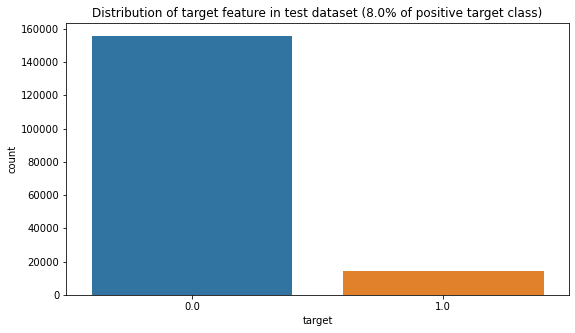

In [86]:
percentage_of_pos_target = round(100*(test_device_model_df.target==1).sum()/len(test_device_model_df),0)
sns.countplot(x=test_device_model_df.target).set_title(f'Distribution of target feature in test dataset ({percentage_of_pos_target}% of positive target class)')
fig = plt.gcf()
fig.set_size_inches( 9, 5)

In [87]:
abon_dpi_agg_test = test_dpi_df.groupby('abon_id').agg({'SUM_of_Duration_sec':'sum','SUM_of_Volume_kb':'sum','SUM_of_Count_events':'sum', 'MAX_of_day_cnt':'mean'})
bnum_df_agg_test = test_b_num_df.groupby('abon_id').agg({'call_cnt_out':'sum','call_cnt_in':'sum','call_dur_out':'sum', 'call_dur_in':'sum', 'cnt_sms_out':'sum', 'cnt_sms_in':'sum'})

In [88]:
test_dpi_df = test_dpi_df.pivot_table(index = test_dpi_df.index, columns= 'Application', values=['SUM_of_Duration_sec','SUM_of_Volume_kb','SUM_of_Count_events','MAX_of_day_cnt'])
test_dpi_df.columns = test_dpi_df.columns.map('{0[1]}|{0[0]}'.format)
test_dpi_df = test_dpi_df.loc[:,[f for f in test_dpi_df.columns if f in train_device_model_df.columns]]

In [89]:
test_b_num_df['bnum'] = [str(f)[2:-1] for f in test_b_num_df['bnum']]
test_b_num_df = test_b_num_df.loc[test_b_num_df.bnum.isin(top_bnum),:]
test_b_num_df = test_b_num_df.pivot_table(index = test_b_num_df.index, columns= 'bnum', values=['call_cnt_out','cnt_sms_in','cnt_sms_out'])
test_b_num_df.columns = test_b_num_df.columns.map('{0[1]}|{0[0]}'.format)
test_b_num_df = test_b_num_df.loc[:,[f for f in test_b_num_df.columns if f in train_device_model_df.columns]]

In [90]:
test_device_model_df = pd.merge(test_device_model_df,test_dpi_df,left_index=True, right_index=True, how = 'left' ).merge(test_b_num_df,left_index=True, right_index=True, how = 'left').merge(abon_dpi_agg_test,left_index=True, right_index=True, how = 'left').merge(bnum_df_agg_test,left_index=True, right_index=True, how = 'left')
test_device_model_df = test_device_model_df.loc[:, [f for f in test_device_model_df.columns if f in train_device_model_df.columns]]

In [91]:
final_columns = set(train_device_model_df.columns).intersection(set(test_device_model_df))
test_device_model_df = test_device_model_df.loc[:,final_columns]
train_device_model_df = train_device_model_df.loc[:,final_columns]

In [92]:
#use train dist
test_device_model_df = test_device_model_df.fillna(train_device_model_df.median())

## 4.2 Training model with best hyperparameters on train dataset

In [93]:
dtrain = lgb.Dataset(train_device_model_df.drop(columns = ['target']), label=train_device_model_df.target)
lgb_final_model = lgb.train(best_params_lgb,dtrain,num_boost_round=1000)

In [94]:
#Saving model to disk
lgb_final_model.save_model('lgb_final_classifier.txt')
lgb_final_model = lgb.Booster(model_file='lgb_final_classifier.txt')

## 4.3 Evaluating model

In [95]:
predictions_prob = lgb_final_model.predict(test_device_model_df.drop(columns = 'target'))

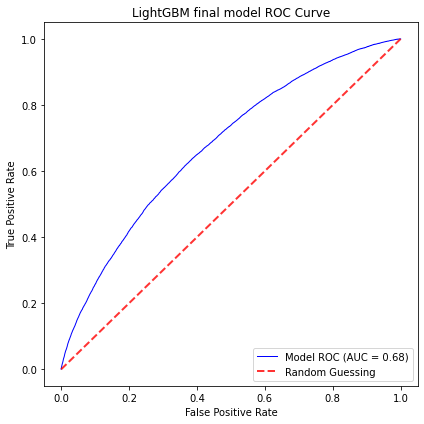

In [96]:
# Plot the ROC curve and get AUC

plt.figure(figsize=(6,6))

fpr, tpr, thresholds = roc_curve(test_device_model_df.target, predictions_prob)
score = roc_auc_score(test_device_model_df.target, predictions_prob)
plt.plot(fpr, tpr, lw=1,color='b',label='Model ROC (AUC = %0.2f)' % ( score))
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guessing', alpha=.8)
fpr, tpr, thresholds = roc_curve(test_device_model_df.target, predictions_prob)
score = roc_auc_score(test_device_model_df.target, predictions_prob)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM final model ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()

### Finding optimal binarization threshold (on validation sets)

#### Option 1) Using ROC curve and Gmean metric, geometric mean of P&R (squared root of presicion*recall)

In [97]:
binarization_thresholds = list()
for i in range(10):
    _, valid_x, _, valid_y = train_test_split(train_device_model_df.drop('target', axis=1), train_device_model_df.target, test_size=0.3)
    predictions_proba = lgb_final_model.predict(valid_x)
    fpr, tpr, thresholds = roc_curve(valid_y, predictions_proba)

    gmeans = np.sqrt(tpr * (1-fpr))

    ix = np.argmax(gmeans)
    best_treshold = thresholds[ix] 
    binarization_thresholds.append(best_treshold)

In [98]:
best_binarization_thresh_Gmean = np.mean(binarization_thresholds)
print(f'Best binarization treshold using Gmean metric={best_binarization_thresh_Gmean.round(4)}')

Best binarization treshold using Gmean metric=0.5081


#### Option 2) Using F-beta score plot for each threshold with lean towards recall, as we are more interested in targeting sufficient amount of subscribers who will change their smartphones, targeting some part of non-interested subscribers is not critical as long as this part is not large enough

<AxesSubplot:>

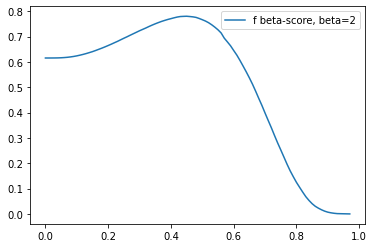

In [99]:
f_scores_list = list()
tresholds = [f*0.01 for f in range(1,99)]
for k in range(5):
    f_scores = list()
    _, valid_x, _, valid_y = train_test_split(train_device_model_df.drop('target', axis=1), train_device_model_df.target, test_size=0.3)
    for i in tresholds:
        predictions_proba = lgb_final_model.predict(valid_x)
        prediction_labels = [ 1 if f>i else 0 for f in predictions_proba]
        
        f_scores.append(fbeta_score(valid_y, prediction_labels, beta=2))
    f_scores_list.append(f_scores)

fscores = pd.DataFrame(pd.DataFrame(f_scores_list).mean(axis=0))
fscores.index =  [f*0.01 for f in fscores.index ]
fscores.columns = ['f beta-score, beta=2']
fscores.plot()

In [111]:
print(f'Optimal threshold using f-beta scores: {fscores.idxmax()}')
best_binarization_thresh = fscores.idxmax()[0]

Optimal threshold using f-beta scores: f beta-score, beta=2    0.45
dtype: float64


### Making predictions on the test set using best binarization threshold and looking at evaluation metrics

In [113]:
#predictions with best binarization treshold
pred_labels =[1 if f>best_binarization_thresh else 0 for f in predictions_prob]

In [114]:
def plot_confusion_matrix(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [115]:
def print_eval_metrics(y_test, prediction):
    print('F1 score: ', round(f1_score(y_test, prediction),2), '\n')
    print('Recall: ', round(recall_score(y_test, prediction),2), '\n')
    print('Precision', round(precision_score(y_test, prediction),2), '\n')
    print('Accuracy: ', round(accuracy_score(y_test, prediction),2), '\n')
    plot_confusion_matrix(confusion_matrix(y_test, prediction))
    print(classification_report(y_test, prediction))

#### Evaluation metrics with optimal binarization treshold using f-beta score with beta = 2 (lean towards recall importancy)

F1 score:  0.22 

Recall:  0.66 

Precision 0.13 

Accuracy:  0.59 

              precision    recall  f1-score   support

         0.0       0.95      0.59      0.73    155662
         1.0       0.13      0.66      0.22     14439

    accuracy                           0.59    170101
   macro avg       0.54      0.62      0.47    170101
weighted avg       0.88      0.59      0.68    170101



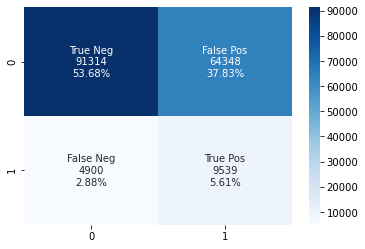

In [116]:
print_eval_metrics(test_device_model_df.target,pred_labels)

#### Evaluation metrics with optimal binarization treshold using Gmean score

In [117]:
pred_labels =[1 if f>best_binarization_thresh_Gmean else 0 for f in predictions_prob]

F1 score:  0.23 

Recall:  0.55 

Precision 0.14 

Accuracy:  0.68 

              precision    recall  f1-score   support

         0.0       0.94      0.70      0.80    155662
         1.0       0.14      0.55      0.23     14439

    accuracy                           0.68    170101
   macro avg       0.54      0.62      0.51    170101
weighted avg       0.88      0.68      0.75    170101



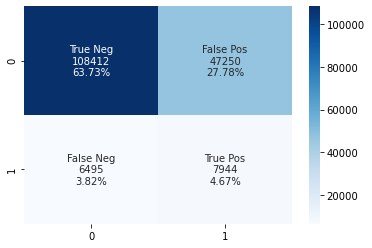

In [118]:
print_eval_metrics(test_device_model_df.target,pred_labels)

#### Looking at features that model considered most important (TOP-20)

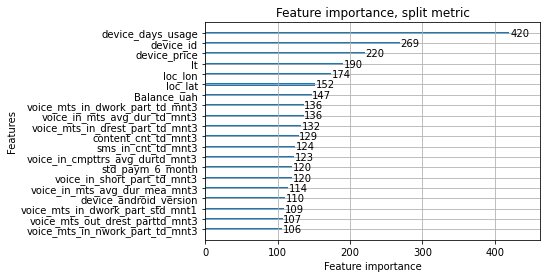

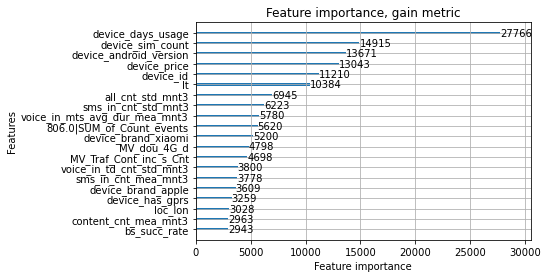

In [119]:
split_plot = lgb.plot_importance(lgb_final_model, importance_type='split', max_num_features=20, title='Feature importance, split metric')

gain_plot = lgb.plot_importance(lgb_final_model, importance_type='gain',max_num_features=20, title='Feature importance, gain metric',precision=0)

In [120]:
#final params
best_params_lgb

{'objective': 'binary',
 'metric': 'auc',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'is_unbalance': True,
 'feature_pre_filter': False,
 'lambda_l1': 8.599914241598706,
 'lambda_l2': 1.2597065318980905e-05,
 'num_leaves': 31,
 'feature_fraction': 0.6479999999999999,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 100}

# 5. Wrapping model in a class and serializing it

In [121]:
class LightGBM_binary_clf():
    
        def __init__(self):
            
            self.binarization_treshold = 0.45
            self.lgb_clf = lgb.Booster(model_file='lgb_final_classifier.txt')
            
            
        def preprocess(self,prediction_data):
            prediction_data = prediction_data.loc[:,[f for f in prediction_data.columns if f in self.lgb_clf.feature_name()]]
            missing_cols = list(set(self.lgb_clf.feature_name()) - set(prediction_data.columns))
            for f in missing_cols:
                prediction_data[f]=0
            return prediction_data
        
        def predict(self,prediction_data):
            prediction_data = self.preprocess(prediction_data)
            pred_proba = self.lgb_clf.predict(prediction_data)
            predictions = [1 if f>self.binarization_treshold else 0 for f in pred_proba]
            return predictions
        

In [122]:
lgb_cls_instance = LightGBM_binary_clf()

joblib.dump(lgb_cls_instance,'Lightgbm_model_wrapped.pkl')

loaded_lgb_instance= joblib.load('Lightgbm_model_wrapped.pkl')

predictions = loaded_lgb_instance.predict(test_device_model_df)

In [123]:
predictions[0:100]

[0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0]

F1 score:  0.22 

Recall:  0.66 

Precision 0.13 

Accuracy:  0.59 

              precision    recall  f1-score   support

         0.0       0.95      0.59      0.73    155662
         1.0       0.13      0.66      0.22     14439

    accuracy                           0.59    170101
   macro avg       0.54      0.62      0.47    170101
weighted avg       0.88      0.59      0.68    170101



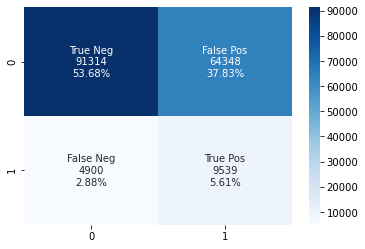

In [124]:
print_eval_metrics(test_device_model_df.target,predictions)